In [ ]:
!pip install Sastrawi

import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn import svm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.7 MB/s eta 0:00:00


# import dataset

In [ ]:
ulasan = pd.read_csv('shopee_ulasan_label7.csv')
ulasan.head(10)

,user,ulasan,rating,label,tanggal
0,Juwairiah Juwairiah,Aplikasi shopee aku kok gak bisa gunain gratis...,1,negatif,06 Maret 2021
1,Sabyan Keisha,Menyebalkan vocer penguna baru tidak bisa di p...,1,negatif,12 Maret 2021
2,Teno Tee,"Saya sebagai penjual kecewa, penarikan saldo m...",1,negatif,27 Februari 2021
3,Nana nae,Aplukasi apa sih ini disuruh buat nama uda gue...,1,negatif,03 Maret 2021
4,Nurul Hamidah,Makin kesini Shoppe makin gak jelas. Apaan kab...,1,negatif,14 Maret 2021
5,Muhammad Barcha,Shopee sangat memgecewakan voucher jambore nya...,1,negatif,13 Maret 2021
6,Nur Rofa'ah,"Aplikasi g guna, g bisa ngakses nomor, padahal...",1,negatif,28 Februari 2021
7,Ramses Pandapotan,Saya gamau ganti bintang kecuali shopee udah k...,1,negatif,17 Maret 2021
8,Login Ml woi,Sumpah shopee makin lama makin gila Karena Say...,1,negatif,03 Maret 2021
9,Andika Pratama,"Aplikasi penipu, bilangnya baru pertama kali d...",1,negatif,13 Maret 2021


# cleansing

In [ ]:
def cleaningulasan(ulasan):

  ulasan = re.sub(r'#[A-Za-z0-9]+',' ',ulasan)
  ulasan = re.sub(r"http\S+",' ',ulasan)
  ulasan = re.sub(r'[0-9]+',' ',ulasan)
  ulasan = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", ulasan)
  #menghapus karakter tunggal
  ulasan = re.sub(r"\b[a-zA-Z]\b", " ", ulasan)
  ulasan = ulasan.strip(' ')
  return ulasan
ulasan['Cleaning']= ulasan['ulasan'].apply(cleaningulasan)


def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')
ulasan['HapusEmoji']= ulasan['Cleaning'].apply(clearEmoji)

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)
ulasan['cleansing']= ulasan['HapusEmoji'].apply(replaceTOM)

ulasan[['ulasan','cleansing']]
ulasan[['ulasan','cleansing']].to_csv('cleansingb.csv', index=False,float_format='%.2f')

# case folding

In [ ]:
def casefoldingText(ulasan):
  ulasan = ulasan.lower()
  return ulasan
ulasan['CaseFolding']= ulasan['cleansing'].apply(casefoldingText)
ulasan[['cleansing','CaseFolding']]
ulasan[['cleansing','CaseFolding']].to_csv('casefolding.csv', index=False)

# tokenizing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenizingText(ulasan):
  ulasan = word_tokenize(ulasan)
  return ulasan
ulasan['Tokenizing']= ulasan['CaseFolding'].apply(tokenizingText)
ulasan[['CaseFolding','Tokenizing']]
ulasan[['CaseFolding','Tokenizing']].to_csv('tokenizing.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


def stemming(kalimat_baru):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # Lakukan stemming pada setiap kata
    stemmed_words = [stemmer.stem(word) for word in kalimat_baru]
    return stemmed_words

ulasan['Stemming_list'] = ulasan['Tokenizing'].apply(stemming)

#merubah list ke str
ulasan['Stemming'] = ulasan['Stemming_list'].apply(' '.join)

#menampilkan data hasil stemming
ulasan[['Tokenizing','Stemming']]
ulasan[['Tokenizing','Stemming']].to_csv('stemming.csv', index=False)

# negasi handling

In [ ]:
def handle_negation(kalimat_baru):
    negation_words = ["tidak", "bukan", "tak", "tiada", "jangan", "gak"]
    new_words = []
    prev_word_is_negation = False
    for word in kalimat_baru:
        if word in negation_words:
            new_words.append("tidak_")
            prev_word_is_negation = True
        elif prev_word_is_negation:
            new_words[-1] += word
            prev_word_is_negation = False
        else:
            new_words.append(word)
    return new_words
ulasan['negasi'] = ulasan['Stemming_list'].apply(handle_negation)
#menampilkan data hasil stemming
ulasan[['Stemming','negasi']]
ulasan[['Stemming','negasi']].to_csv('negasi.csv', index=False)

# word normalization

In [ ]:
def convertToSlangword(ulasan):
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in ulasan:
        filter_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata.lower())
        if filter_slang.startswith('tidak_'):
          kata_depan = 'tidak_'
          kata_belakang = kata[6:]
          kata_belakang_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata_belakang.lower())
          kata_hasil = kata_depan + kata_belakang_slang
          content.append(kata_hasil)
        else:
          content.append(filter_slang)
    ulasan = content
    return ulasan

ulasan['Formalisasi'] = ulasan['negasi'].apply(convertToSlangword)
ulasan[['negasi','Formalisasi']]
ulasan[['negasi','Formalisasi']].to_csv('word normalization.csv', index=False)

# stopword removal

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Mengunduh daftar stopword dari NLTK
daftar_stopword = stopwords.words('indonesian')

# Menambahkan stopword tambahan
daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk','g'])

# Membaca file teks stopword menggunakan pandas
txt_stopword = pd.read_csv("stopwords.txt", names=["stopwords"], header=None)

# Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
daftar_stopword.extend(txt_stopword['stopwords'].tolist())

# Mengubah daftar stopword menjadi set untuk pencarian yang lebih efisien
daftar_stopword = set(daftar_stopword)

def stopwordText(words):
    cleaned_words = []
    for word in words:
        # Memisahkan kata dengan tambahan "tidak_"
        if word.startswith("tidak_"):
            cleaned_words.append(word[:5])
            cleaned_words.append(word[6:])
        elif word not in daftar_stopword:
            cleaned_words.append(word)
    return cleaned_words

ulasan['Stopword_list'] = ulasan['Formalisasi'].apply(stopwordText)
#merubah list ke str
ulasan['Stopword Removal'] = ulasan['Stopword_list'].apply(' '.join)
ulasan[['Formalisasi','Stopword Removal']].to_csv('stopword.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
ulasan.to_csv('dataset_bersih.csv',index=False)

In [ ]:
#Install Library Googletrans
!pip3 install googletrans==3.1.0a0
import googletrans
from googletrans import *
translator = googletrans.Translator()
df = pd.read_csv('dataset_bersih.csv')
df['Stopword Removal'] = df['Stopword Removal'].astype(str) #Ubah tipe data ke string
df['English_Tweet'] = df['Stopword Removal'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',))
df
#Simpan data terjemahan inggris ke file csv
df.to_csv('dataset_ing.csv')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16352 sha256=27a9acf6706ff707b57a40916a3e7d52b5aebf87c64f68bd543f50025f38b80f
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [ ]:
import pandas as pd
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Inisialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan label berdasarkan nilai sentimen
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'

# Membaca file CSV dengan kolom 'ulasan'
data = pd.read_csv('dataset_ing.csv')

# Membuat kolom baru untuk menyimpan hasil pelabelan
data['sentimen'] = ""

# Melakukan pelabelan pada setiap ulasan
for index, row in data.iterrows():
    ulasan = row['English_Tweet']
    sentiment_score = sia.polarity_scores(ulasan)['compound']
    label = get_sentiment_label(sentiment_score)
    data.at[index, 'sentimen'] = label

# Menyimpan hasil pelabelan ke file CSV
output_path = 'hasil_sentimen.csv'  # Ganti dengan path tujuan Anda
data.to_csv(output_path, index=False)

print("Pelabelan selesai. Hasil disimpan di:", output_path)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Pelabelan selesai. Hasil disimpan di: hasil_sentimen.csv


In [ ]:
ulasan = pd.read_csv('hasil_sentimen.csv')
ulasan['sentimen'].value_counts()

positif    1994
negatif     730
netral      213
Name: sentimen, dtype: int64

In [ ]:
# Membuat DataFrame baru hanya dengan sentimen netral
sentimen_netral = ulasan[ulasan['sentimen'] == 'negatif']

# Menyimpan DataFrame baru ke dalam file CSV jika diperlukan
sentimen_netral.to_csv('sentimen_negatif.csv', index=False)

jumlah sentimen :
positif    1994
negatif     730
netral      213
Name: sentimen, dtype: int64


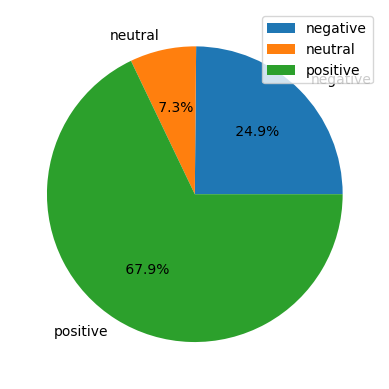

In [ ]:
# melihat jumlah kelas sentimen
Jumlah_sentimen = ulasan['sentimen'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)
# menampilkan dalam bentuk plot diagram
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['negative' , 'neutral', 'positive']
plt.pie(ulasan.groupby('sentimen')['sentimen'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.show()

In [ ]:
# Fungsi subjectivity(menentukan opini) dan polarity(menentukan sentimen)
# Membaca file CSV dengan kolom 'ulasan'

from textblob import TextBlob
df = pd.read_csv('dataset_ing.csv')
df['English_Tweet'] = df['English_Tweet'].astype(str)

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['English_Tweet'].apply(getSubjectivity)
df['Polarity'] = df['English_Tweet'].apply(getPolarity)

df.head()

,Unnamed: 0,user,ulasan,rating,label,tanggal,Cleaning,HapusEmoji,cleansing,CaseFolding,Tokenizing,Stemming_list,Stemming,negasi,Formalisasi,Stopword_list,Stopword Removal,English_Tweet,Subjectivity,Polarity
0,0,Juwairiah Juwairiah,Aplikasi shopee aku kok gak bisa gunain gratis...,1,negatif,06 Maret 2021,Aplikasi shopee aku kok gak bisa gunain gratis...,Aplikasi shopee aku kok gak bisa gunain gratis...,Aplikasi shopee aku kok gak bisa gunain gratis...,aplikasi shopee aku kok gak bisa gunain gratis...,"['aplikasi', 'shopee', 'aku', 'kok', 'gak', 'b...","['aplikasi', 'shopee', 'aku', 'kok', 'gak', 'b...",aplikasi shopee aku kok gak bisa gunain gratis...,"['aplikasi', 'shopee', 'aku', 'kok', 'tidak_bi...","['aplikasi', 'shopee', 'aku', 'kok', 'tidak_bi...","['aplikasi', 'shopee', 'tidak', 'bisa', 'gunai...",aplikasi shopee tidak bisa gunain gratis ongko...,Shopee application can't use free Rupiah shipp...,0.800000,0.400
1,1,Sabyan Keisha,Menyebalkan vocer penguna baru tidak bisa di p...,1,negatif,12 Maret 2021,Menyebalkan vocer penguna baru tidak bisa di p...,Menyebalkan vocer penguna baru tidak bisa di p...,Menyebalkan vocer penguna baru tidak bisa di p...,menyebalkan vocer penguna baru tidak bisa di p...,"['menyebalkan', 'vocer', 'penguna', 'baru', 't...","['sebal', 'vocer', 'penguna', 'baru', 'tidak',...",sebal vocer penguna baru tidak bisa di pakek k...,"['sebal', 'vocer', 'penguna', 'baru', 'tidak_b...","['sebal', 'voucer', 'konsumen', 'baru', 'tidak...","['sebal', 'voucer', 'konsumen', 'tidak', 'bisa...",sebal voucer konsumen tidak bisa pakai udh pak...,annoyed that the consumer can't use the vouche...,0.800000,-0.400
2,2,Teno Tee,"Saya sebagai penjual kecewa, penarikan saldo m...",1,negatif,27 Februari 2021,Saya sebagai penjual kecewa penarikan saldo m...,Saya sebagai penjual kecewa penarikan saldo m...,Saya sebagai penjual kecewa penarikan saldo m...,saya sebagai penjual kecewa penarikan saldo m...,"['saya', 'sebagai', 'penjual', 'kecewa', 'pena...","['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...",saya bagai jual kecewa tari saldo lalu bank la...,"['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...","['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...","['jual', 'kecewa', 'tari', 'saldo', 'bank', 'b...",jual kecewa tari saldo bank bank teknologi can...,"Selling disappointed with bank balance, advanc...",0.675000,-0.175
3,3,Nana nae,Aplukasi apa sih ini disuruh buat nama uda gue...,1,negatif,03 Maret 2021,Aplukasi apa sih ini disuruh buat nama uda gue...,Aplukasi apa sih ini disuruh buat nama uda gue...,Aplukasi apa sih ini disuruh buat nama uda gue...,aplukasi apa sih ini disuruh buat nama uda gue...,"['aplukasi', 'apa', 'sih', 'ini', 'disuruh', '...","['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...",aplukasi apa sih ini suruh buat nama uda gue t...,"['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...","['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...","['aplukasi', 'sih', 'suruh', 'nama', 'uda', 't...",aplukasi sih suruh nama uda tulis nama tidak t...,the application says name already written name...,0.600000,0.000
4,4,Nurul Hamidah,Makin kesini Shoppe makin gak jelas. Apaan kab...,1,negatif,14 Maret 2021,Makin kesini Shoppe makin gak jelas Apaan kab...,Makin kesini Shoppe makin gak jelas Apaan kab...,Makin kesini Shoppe makin gak jelas Apaan kab...,makin kesini shoppe makin gak jelas apaan kab...,"['makin', 'kesini', 'shoppe', 'makin', 'gak', ...","['makin', 'kesini', 'shoppe', 'makin', 'gak', ...",makin kesini shoppe makin gak jelas apa kabany...,"['makin', 'kesini', 'shoppe', 'makin', 'tidak_...","['makin', 'kesini', 'shoppe', 'makin', 'tidak_...","['kesini', 'shoppe', 'tidak', 'jelas', 'kabany...",kesini shoppe tidak jelas kabanyakan limit bel...,"Here, Shopee is not clear about most shopping ...",0.441667,0.225


In [ ]:
# Melakukan Labelling
def getSentiment(score):
    if score < 0 :
        return 'Negative'
    elif score == 0 :
        return 'Netral'
    else :
        return 'Positive'

df['Sentiment'] = df['Polarity'].apply(getSentiment)

df
# Menyimpan hasil pelabelan ke file CSV
output_path = 'sentimen_textblob.csv'  # Ganti dengan path tujuan Anda
df.to_csv(output_path, index=False)

jumlah sentimen :
Positive    1750
Negative     785
Netral       402
Name: Sentiment, dtype: int64


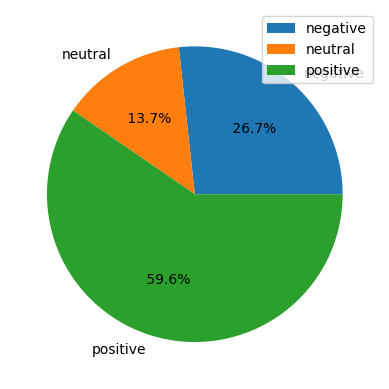

In [ ]:
textblob = pd.read_csv('sentimen_textblob.csv')
textblob['Sentiment'].value_counts()
# melihat jumlah kelas sentimen
Jumlah_sentimen = textblob['Sentiment'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)
# menampilkan dalam bentuk plot diagram
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['negative' , 'neutral', 'positive']
plt.pie(textblob.groupby('Sentiment')['Sentiment'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.show()

In [ ]:
textblob.head(10)

,Unnamed: 0,user,ulasan,rating,label,tanggal,Cleaning,HapusEmoji,cleansing,CaseFolding,...,Stemming_list,Stemming,negasi,Formalisasi,Stopword_list,Stopword Removal,English_Tweet,Subjectivity,Polarity,Sentiment
0,0,Juwairiah Juwairiah,Aplikasi shopee aku kok gak bisa gunain gratis...,1,negatif,06 Maret 2021,Aplikasi shopee aku kok gak bisa gunain gratis...,Aplikasi shopee aku kok gak bisa gunain gratis...,Aplikasi shopee aku kok gak bisa gunain gratis...,aplikasi shopee aku kok gak bisa gunain gratis...,...,"['aplikasi', 'shopee', 'aku', 'kok', 'gak', 'b...",aplikasi shopee aku kok gak bisa gunain gratis...,"['aplikasi', 'shopee', 'aku', 'kok', 'tidak_bi...","['aplikasi', 'shopee', 'aku', 'kok', 'tidak_bi...","['aplikasi', 'shopee', 'tidak', 'bisa', 'gunai...",aplikasi shopee tidak bisa gunain gratis ongko...,Shopee application can't use free Rupiah shipp...,0.800000,0.400000,Positive
1,1,Sabyan Keisha,Menyebalkan vocer penguna baru tidak bisa di p...,1,negatif,12 Maret 2021,Menyebalkan vocer penguna baru tidak bisa di p...,Menyebalkan vocer penguna baru tidak bisa di p...,Menyebalkan vocer penguna baru tidak bisa di p...,menyebalkan vocer penguna baru tidak bisa di p...,...,"['sebal', 'vocer', 'penguna', 'baru', 'tidak',...",sebal vocer penguna baru tidak bisa di pakek k...,"['sebal', 'vocer', 'penguna', 'baru', 'tidak_b...","['sebal', 'voucer', 'konsumen', 'baru', 'tidak...","['sebal', 'voucer', 'konsumen', 'tidak', 'bisa...",sebal voucer konsumen tidak bisa pakai udh pak...,annoyed that the consumer can't use the vouche...,0.800000,-0.400000,Negative
2,2,Teno Tee,"Saya sebagai penjual kecewa, penarikan saldo m...",1,negatif,27 Februari 2021,Saya sebagai penjual kecewa penarikan saldo m...,Saya sebagai penjual kecewa penarikan saldo m...,Saya sebagai penjual kecewa penarikan saldo m...,saya sebagai penjual kecewa penarikan saldo m...,...,"['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...",saya bagai jual kecewa tari saldo lalu bank la...,"['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...","['saya', 'bagai', 'jual', 'kecewa', 'tari', 's...","['jual', 'kecewa', 'tari', 'saldo', 'bank', 'b...",jual kecewa tari saldo bank bank teknologi can...,"Selling disappointed with bank balance, advanc...",0.675000,-0.175000,Negative
3,3,Nana nae,Aplukasi apa sih ini disuruh buat nama uda gue...,1,negatif,03 Maret 2021,Aplukasi apa sih ini disuruh buat nama uda gue...,Aplukasi apa sih ini disuruh buat nama uda gue...,Aplukasi apa sih ini disuruh buat nama uda gue...,aplukasi apa sih ini disuruh buat nama uda gue...,...,"['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...",aplukasi apa sih ini suruh buat nama uda gue t...,"['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...","['aplukasi', 'apa', 'sih', 'ini', 'suruh', 'bu...","['aplukasi', 'sih', 'suruh', 'nama', 'uda', 't...",aplukasi sih suruh nama uda tulis nama tidak t...,the application says name already written name...,0.600000,0.000000,Netral
4,4,Nurul Hamidah,Makin kesini Shoppe makin gak jelas. Apaan kab...,1,negatif,14 Maret 2021,Makin kesini Shoppe makin gak jelas Apaan kab...,Makin kesini Shoppe makin gak jelas Apaan kab...,Makin kesini Shoppe makin gak jelas Apaan kab...,makin kesini shoppe makin gak jelas apaan kab...,...,"['makin', 'kesini', 'shoppe', 'makin', 'gak', ...",makin kesini shoppe makin gak jelas apa kabany...,"['makin', 'kesini', 'shoppe', 'makin', 'tidak_...","['makin', 'kesini', 'shoppe', 'makin', 'tidak_...","['kesini', 'shoppe', 'tidak', 'jelas', 'kabany...",kesini shoppe tidak jelas kabanyakan limit bel...,"Here, Shopee is not clear about most shopping ...",0.441667,0.225000,Positive
5,5,Muhammad Barcha,Shopee sangat memgecewakan voucher jambore nya...,1,negatif,13 Maret 2021,Shopee sangat memgecewakan voucher jambore nya...,Shopee sangat memgecewakan voucher jambore nya...,Shopee sangat memgecewakan voucher jambore nya...,shopee sangat memgecewakan voucher jambore nya...,...,"['shopee', 'sangat', 'memgecewakan', 'voucher'...",shopee sangat memgecewakan voucher jam

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = textblob['Stopword Removal']
Y = textblob['Sentiment']

x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.2)

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)
# Encoder = LabelEncoder()
# y_train = Encoder.fit_transform(y_train)
# y_test = Encoder.fit_transform(y_test)

# Create CountVectorizer instance
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(X)

# Create TfidfTransformer instance
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)

# Create TfidfVectorizer instance
tfidf_vectorizer = TfidfVectorizer()
X_tfidf_vectorized = tfidf_vectorizer.fit_transform(X)

# mengambil kata asli from CountVectorizer or TfidfVectorizer
feature_names = count_vectorizer.get_feature_names_out()  # or tfidf_vectorizer.get_feature_names()

# Create a dictionary to store the results
results = {"Ulasan": [], "Term": [], "TF": [], "IDF": [], "TF-IDF": []}

# Loop over the documents
for i in range(len(X)):
    # Add the document to the results dictionary
    results["Ulasan"].extend([f" ulasan{i+1}"] * len(feature_names))
    # Add the feature names to the results dictionary
    results["Term"].extend(feature_names)
    # Calculate the TF, IDF, and TF-IDF for each feature in the document
    for j, feature in enumerate(feature_names):
        tf = X_count[i, j]
        idf = tfidf_transformer.idf_[j]  # or X_tfidf_vectorized.idf_[j]
        tf_idf_score = X_tfidf[i, j]  # or X_tfidf_vectorized[i, j]
        # Add the results to the dictionary
        results["TF"].append(tf)
        results["IDF"].append(idf)
        results["TF-IDF"].append(tf_idf_score)
# Convert the results dictionary to a Pandas dataframe
df = pd.DataFrame(results)


# Save the results to a CSV file
df.to_csv("tf_idf_results.csv", index=False)

#filter nilai term
newdf = df[(df.TF != 0 )]

# Save the results to a CSV file
newdf.to_csv("hasil TF IDF.csv", index=False)

72.78911564625851
              precision    recall  f1-score   support

    Negative       0.75      0.56      0.64       167
      Netral       0.89      0.10      0.18        81
    Positive       0.72      0.96      0.82       340

    accuracy                           0.73       588
   macro avg       0.79      0.54      0.55       588
weighted avg       0.75      0.73      0.68       588



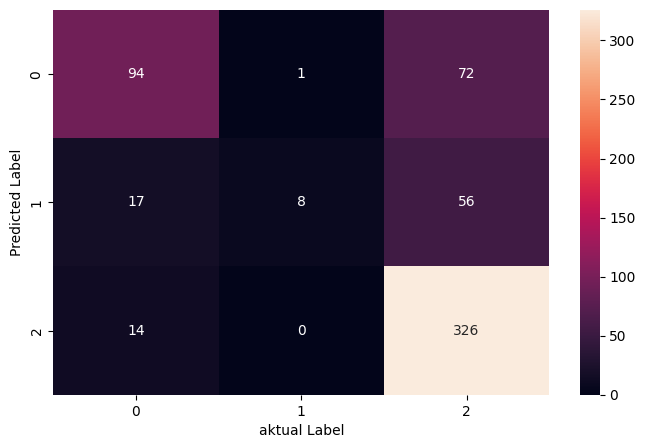

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import pickle
# Making the SVM Classifer
norm_svm_sebelum_smote = svm.SVC()

# Training the model on the training data and labels
norm_svm_sebelum_smote.fit(x_train, y_train)

# Using the model to predict the labels of the test data
y_pred = norm_svm_sebelum_smote.predict(x_test)

acc = accuracy_score(y_test,y_pred)*100
print(acc)
print(classification_report(y_test,y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel('aktual Label')
plt.ylabel('Predicted Label')
plt.show()

# save the model to disk
filename = 'svm_model.pkl'
pickle.dump(norm_svm_sebelum_smote, open(filename, 'wb'))

In [ ]:
import pickle
def prepro(kalimatbaru):
    kcleansing = cleaningulasan(kalimatbaru)
    print('hasil cleaningulasan',kcleansing)

    kcasefolding = casefoldingText(kcleansing)
    print('hasil casefoldingText',kcasefolding)

    ktokenizing = tokenizingText(kcasefolding)
    print('hasil tokenizingText',ktokenizing)

    kstemming = stemming(ktokenizing)
    print('hasil stemming',kstemming)

    knegasi= handle_negation(kstemming)
    print('hasil handle_negation',knegasi)

    kslangword = convertToSlangword(knegasi)
    print('hasil convertToSlangword',kslangword)

    kstopword = stopwordText(kslangword)
    print('hasil stopwordText',kstopword)

    kdatastr = str(kstopword)
    ktfidf =vectorizer.transform([kdatastr])
    return ktfidf
kalimatbaru='shoppe bagus banget'
hasilprepro=prepro(kalimatbaru)
print("ini hasil prepro",hasilprepro)

# with open('svm_textblob.pkl', 'rb') as model_file:
#     loaded_svm_model = pickle.load(model_file)
# predictions = loaded_svm_model.predict(hasilprepro)
# print("ini hasil prediksi",predictions)


hasil cleaningulasan shoppe bagus banget
hasil casefoldingText shoppe bagus banget
hasil tokenizingText ['shoppe', 'bagus', 'banget']
hasil stemming ['shoppe', 'bagus', 'banget']
hasil handle_negation ['shoppe', 'bagus', 'banget']
hasil convertToSlangword ['shoppe', 'bagus', 'banget']
hasil stopwordText ['shoppe', 'bagus', 'banget']
ini hasil prepro   (0, 3214)	0.7288964959763494
  (0, 268)	0.4748699204569324
  (0, 231)	0.49316169437480295


In [ ]:
x_smote =vectorizer.fit_transform(textblob['Stopword Removal'])
y_smote =textblob['Sentiment']

from imblearn.over_sampling import SMOTE
from collections import Counter

print(f'Dataset sebelum SMOTE : {Counter(Y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(x_smote, y_smote)

print(f'Dataset sesudah SMOTE : {Counter(y_res)}')

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.20)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import svm
# Making the SVM Classifer
SVM_sesudah_smote = svm.SVC(kernel='rbf')

# Training the model on the training data and labels
SVM_sesudah_smote.fit(X_train, Y_train)

# Using the model to predict the labels of the test data
y_predgasvmsmote = SVM_sesudah_smote.predict(X_test)

acc = accuracy_score(Y_test,y_predgasvmsmote)*100
print(acc)
print(classification_report(Y_test,y_predgasvmsmote))

import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(Y_test, y_predgasvmsmote), annot=True, fmt=".0f", ax=ax)
plt.xlabel('aktual Label')
plt.ylabel('Predicted Label')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.metrics import recall_score,precision_score

k = 5

acc_svm=cross_val_score(norm_svm_sebelum_smote, x_smote, y_smote, cv=k)
acc_GAsvm=cross_val_score(SVM_sesudah_smote, x_smote, y_smote, cv=k)

plt.plot(range(1, k+1),acc_svm, '-o', label='SVM')
for x,y in zip(range(1, k+1),acc_svm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)

plt.plot(range(1, k+1), acc_GAsvm, '-o', label='smote-SVM')
for x,y in zip(range(1, k+1),acc_GAsvm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)
plt.xlabel('K-fold')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.savefig('kfold_cross_validation.png')
plt.show()

prec_svm = cross_val_score(norm_svm_sebelum_smote, x_smote, y_smote, cv=k,scoring='precision_macro')
prec_GAsvm = cross_val_score(SVM_sesudah_smote, x_smote, y_smote, cv=k,scoring='precision_macro')

plt.plot(range(1, k+1),prec_svm, '-o', label='SVM')
for x,y in zip(range(1, k+1),prec_svm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)

plt.plot(range(1, k+1),prec_GAsvm, '-o', label='smote-SVM')
for x,y in zip(range(1, k+1),prec_GAsvm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)
plt.xlabel('K-fold')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()


rec_svm = cross_val_score(norm_svm_sebelum_smote, x_smote, y_smote, cv=k,scoring='recall_macro')
rec_GAsvm = cross_val_score(SVM_sesudah_smote, x_smote, y_smote, cv=k,scoring='recall_macro')

plt.plot(range(1, k+1),rec_svm, '-o', label='SVM')
for x,y in zip(range(1, k+1),rec_svm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)

plt.plot(range(1, k+1),rec_GAsvm, '-o', label='smote-SVM')
for x,y in zip(range(1, k+1),rec_GAsvm):
    plt.text(x, y, '{:.2f}'.format(y), ha='center', va='bottom', fontsize=10)
plt.xlabel('K-fold')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()